## Cluster Analysis

This script imports the filtered data and runs cluster analysis
filtered_data.csv: rows where userIDs have <3 entries are removed

In [3]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [4]:
import h2o
from h2o.frame import H2OFrame
from h2o.estimators import H2OGeneralizedLowRankEstimator
from h2o.estimators import H2OKMeansEstimator
import warnings

## Import Endo Data

In [6]:
# Read in filtered data
h2o.init()
file_path = 'data/filtered_data.csv'
data = h2o.import_file(file_path)
#data.columns
#data.head()
data.shape

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_421"; Java(TM) SE Runtime Environment (build 1.8.0_421-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.421-b09, mixed mode)
  Starting server from /Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/6c/xr_8v79n1619p54spnzz7l240000gn/T/tmpkuxdlzx1
  JVM stdout: /var/folders/6c/xr_8v79n1619p54spnzz7l240000gn/T/tmpkuxdlzx1/h2o_michelle_started_from_python.out
  JVM stderr: /var/folders/6c/xr_8v79n1619p54spnzz7l240000gn/T/tmpkuxdlzx1/h2o_michelle_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Europe/Dublin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,1 month and 20 days
H2O_cluster_name:,H2O_from_python_michelle_eahcby
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.542 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


(26141, 47)

In [7]:
# Specify the columns to be ignored
ignore_columns = ["date", "datetime", "create_date", "updated_date", "periodID", "water", "nutrition", "medication", "notes", "other_moods", "other_lifestyles"]
data = data.drop(ignore_columns)
data.shape

(26141, 36)

In [8]:
# Read in NLP text classification data
file_path = 'data/text_df.csv'
text_df = h2o.import_file(file_path)
text_df = text_df.drop(['label','userID'], axis=1)

# Merge work_affected column into data on 'ID' 
data = data.merge(text_df, all_x=True, all_y=False)
print(text_df.shape)
data.head(4)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(6227, 2)


ID,userID,period,sex,period_intensity,pain_level,backaches,bodyaches,stomach_cramps,joint_pains,tender_breasts,overall_pain,headache,indigestion,bloating,constipation,diarrhea,nausea,vomiting,appetite_loss,cravings_salty,cravings_sweet,skin_changes,acne,tiredness,dizziness,pins_and_needles,temperature,fever,hot_flashes,short_of_breath,coughing,insomnia,sleep,weight,steps,work_affected
234,95,0,0,nan,nan,2,2,1,2,1,2,1,1,1,0,nan,1,nan,1,1,1,nan,1,1,2,1,0,0,nan,1,nan,0,nan,nan,nan,nan
235,96,1,0,0,nan,0,0,0,1,0,0,0,0,2,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,nan,nan,10000,nan
243,93,0,1,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
244,103,0,0,nan,nan,0,1,0,0,nan,1,nan,nan,2,nan,nan,nan,nan,nan,0,0,nan,0,1,nan,nan,nan,nan,nan,nan,nan,0,nan,nan,nan,nan


In [9]:
# Convert columns to categorical 
categorical_columns = ['period', 'sex', 'period_intensity', 'pain_level','backaches', 
                       'bodyaches', 'stomach_cramps', 'joint_pains', 'tender_breasts', 'overall_pain', 'headache',
                       'indigestion', 'bloating','constipation', 'diarrhea','nausea', 'vomiting', 'appetite_loss', 
                       'cravings_salty','cravings_sweet', 'skin_changes', 'acne','tiredness','dizziness',
                       'pins_and_needles','temperature','fever','hot_flashes','short_of_breath','coughing', 'insomnia', 'work_affected']

for col in categorical_columns:
    data[col] = data[col].asfactor()

# View the data types of columns to verify
data.types

{'ID': 'int',
 'userID': 'int',
 'period': 'enum',
 'sex': 'enum',
 'period_intensity': 'enum',
 'pain_level': 'enum',
 'backaches': 'enum',
 'bodyaches': 'enum',
 'stomach_cramps': 'enum',
 'joint_pains': 'enum',
 'tender_breasts': 'enum',
 'overall_pain': 'enum',
 'headache': 'enum',
 'indigestion': 'enum',
 'bloating': 'enum',
 'constipation': 'enum',
 'diarrhea': 'enum',
 'nausea': 'enum',
 'vomiting': 'enum',
 'appetite_loss': 'enum',
 'cravings_salty': 'enum',
 'cravings_sweet': 'enum',
 'skin_changes': 'enum',
 'acne': 'enum',
 'tiredness': 'enum',
 'dizziness': 'enum',
 'pins_and_needles': 'enum',
 'temperature': 'enum',
 'fever': 'enum',
 'hot_flashes': 'enum',
 'short_of_breath': 'enum',
 'coughing': 'enum',
 'insomnia': 'enum',
 'sleep': 'int',
 'weight': 'real',
 'steps': 'int',
 'work_affected': 'enum'}

In [10]:
# Aggregate rows with the same date
data_h2o = H2OFrame(data)

# Define aggregation
grouped = data_h2o.group_by("userID")

# Apply max aggregation to the relevant columns
grouped = grouped.max("period") \
                 .max("sex") \
                 .max("period_intensity") \
                 .max("pain_level") \
                 .max("backaches") \
                 .max("bodyaches") \
                 .max("stomach_cramps") \
                 .max("joint_pains") \
                 .max("tender_breasts") \
                 .max("overall_pain") \
                 .max("headache") \
                 .max("indigestion") \
                 .max("bloating") \
                 .max("constipation") \
                 .max("diarrhea") \
                 .max("nausea") \
                 .max("vomiting") \
                 .max("appetite_loss") \
                 .max("cravings_salty") \
                 .max("cravings_sweet") \
                 .max("skin_changes") \
                 .max("acne") \
                 .max("tiredness") \
                 .max("dizziness") \
                 .max("pins_and_needles") \
                 .max("temperature") \
                 .max("fever") \
                 .max("hot_flashes") \
                 .max("short_of_breath") \
                 .max("coughing") \
                 .max("insomnia") \
                 .max("work_affected")

# Apply mean aggregation to the relevant columns
grouped = grouped.mean("weight") \
                 .mean("sleep") \
                 .mean("steps") 

# Get aggregated H2OFrame & drop UserID
agg_data = grouped.get_frame()
#agg_data.head(4)

In [11]:
# Drop the userID column
agg_data = agg_data.drop(['userID'])
print(agg_data.shape)


(1918, 35)


In [12]:
# List of new column names
revert_column_names = ['period', 'sex', 'period_intensity', 'pain_level','backaches', 
                'bodyaches', 'stomach_cramps', 'joint_pains', 'tender_breasts', 'overall_pain', 'headache',
                'indigestion', 'bloating','constipation', 'diarrhea', 'nausea', 'vomiting', 'appetite_loss', 
                'cravings_salty', 'cravings_sweet', 'skin_changes', 'acne', 'tiredness', 'dizziness',
                'pins_and_needles', 'temperature', 'fever', 'hot_flashes', 'short_of_breath', 'coughing', 
                'insomnia', 'work_affected', 'weight', 'sleep', 'steps']

# Revert the columns
agg_data = agg_data.set_names(revert_column_names)

# Convert columns to categorical 
categorical_columns = ['period', 'sex', 'period_intensity', 'pain_level','backaches', 
                'bodyaches', 'stomach_cramps', 'joint_pains', 'tender_breasts', 'overall_pain', 'headache',
                'indigestion', 'bloating','constipation', 'diarrhea', 'nausea', 'vomiting', 'appetite_loss', 
                'cravings_salty', 'cravings_sweet', 'skin_changes', 'acne', 'tiredness', 'dizziness',
                'pins_and_needles', 'temperature', 'fever', 'hot_flashes', 'short_of_breath', 'coughing', 
                'insomnia', 'work_affected']

for col in categorical_columns:
    if col in agg_data.columns:
        agg_data[col] = agg_data[col].asfactor()

agg_data.types

{'period': 'enum',
 'sex': 'enum',
 'period_intensity': 'enum',
 'pain_level': 'enum',
 'backaches': 'enum',
 'bodyaches': 'enum',
 'stomach_cramps': 'enum',
 'joint_pains': 'enum',
 'tender_breasts': 'enum',
 'overall_pain': 'enum',
 'headache': 'enum',
 'indigestion': 'enum',
 'bloating': 'enum',
 'constipation': 'enum',
 'diarrhea': 'enum',
 'nausea': 'enum',
 'vomiting': 'enum',
 'appetite_loss': 'enum',
 'cravings_salty': 'enum',
 'cravings_sweet': 'enum',
 'skin_changes': 'enum',
 'acne': 'enum',
 'tiredness': 'enum',
 'dizziness': 'enum',
 'pins_and_needles': 'enum',
 'temperature': 'enum',
 'fever': 'enum',
 'hot_flashes': 'enum',
 'short_of_breath': 'enum',
 'coughing': 'enum',
 'insomnia': 'enum',
 'work_affected': 'enum',
 'weight': 'real',
 'sleep': 'real',
 'steps': 'real'}

In [13]:
# Specify the data type for each column
loss_by_col = ['Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Categorical', 'Quadratic', 'Quadratic', 'Quadratic']


# GLRM Model

#### Generalized Low Rank Model

In [16]:
# Build and train the model
glrm_model = H2OGeneralizedLowRankEstimator(
    k=18,
    loss_by_col=loss_by_col,
    transform="standardize",
    seed=1234
)

# Train model
glrm_model.train(training_frame=agg_data)

glrm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLowRankEstimator : Generalized Low Rank Modeling
Model Key: GLRM_model_python_1725035253807_1


Model Summary: 
    number_of_iterations    final_step_size    final_objective_value
--  ----------------------  -----------------  -----------------------
    450                     1.77725e-05        5.72945e-26

ModelMetricsGLRM: glrm
** Reported on train data. **

MSE: NaN
RMSE: NaN
Sum of Squared Error (Numeric): 3.0921125895491864e-13
Misclassification Error (Categorical): 0.0

Scoring History: 
     timestamp            duration    iterations    step_size               objective
---  -------------------  ----------  ------------  ----------------------  ---------------------
     2024-08-30 17:27:53  1.034 sec   0.0           1.05                    13023.100926795089
     2024-08-30 17:27:53  1.162 sec   1.0           1.1025                  7991.833487434823
     2024-08-30 17:27:53  1.264 sec   2.0           1.1576250000000001      5438.958138859884
     2024-08-30 17:27:53  1.376 sec   3.0           1.2155062500000002      4059.16407377393
     2024-08-30 17:27:53  1.490 sec   4.0           1.2762815625000004      3076.365497598751
     2024-08-30 17:27:54  1.595 sec   5.0           1.3400956406250004      2561.263681987434
     2024-08-30 17:27:54  1.698 sec   6.0           1.4071004226562505      2018.0833281243886
     2024-08-30 17:27:54  1.785 sec   7.0           1.477455443789063       1669.1146817130634
     2024-08-30 17:27:54  1.905 sec   8.0           1.5513282159785162      1427.1191747055905
     2024-08-30 17:27:54  1.981 sec   9.0           1.628894626777442       1243.0707499375462
---  ---                  ---         ---           ---                     ---
     2024-08-30 17:28:05  12.775 sec  440.0         0.30231032736001523     5.729446290816999e-26
     2024-08-30 17:28:05  12.793 sec  441.0         0.20154021824001014     5.729446290816999e-26
     2024-08-30 17:28:05  12.810 sec  442.0         0.1343601454933401      5.729446290816999e-26
     2024-08-30 17:28:05  12.828 sec  443.0         0.08957343032889341     5.729446290816999e-26
     2024-08-30 17:28:05  12.865 sec  444.0         0.044786715164446704    5.729446290816999e-26
     2024-08-30 17:28:05  12.895 sec  445.0         0.014928905054815568    5.729446290816999e-26
     2024-08-30 17:28:05  12.919 sec  446.0         0.003732226263703892    5.729446290816999e-26
     2024-08-30 17:28:05  12.943 sec  447.0         0.0007464452527407784   5.729446290816999e-26
     2024-08-30 17:28:05  12.964 sec  448.0         0.00012440754212346305  5.729446290816999e-26
     2024-08-30 17:28:05  12.981 sec  449.0         1.777250601763758e-05   5.729446290816999e-26
[450 rows x 6 columns]


[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [17]:
# Evaluate model performance on training data
performance = glrm_model.model_performance()
perf = glrm_model.model_performance(agg_data)
perf

ModelMetricsGLRM: glrm
** Reported on test data. **

MSE: NaN
RMSE: NaN
Sum of Squared Error (Numeric): 3.0921125895491864e-13
Misclassification Error (Categorical): 0.0

In [18]:
# Extract the low-rank representation (X)
X = glrm_model._model_json['output']['representation_name']
A_low_rank_rep = h2o.get_frame(X)

# Transform the valid  data to retrieve the new coefficients:
B_glrm_data = glrm_model.transform_frame(agg_data)

In [19]:
A_low_rank_rep.isna().sum()

0.0

# K-means

In [21]:
# Build and train the model:
kmeans_model = H2OKMeansEstimator(k=10,
                                 estimate_k=True,
                                 standardize=False,
                                 seed=1234)

kmeans_model.train(training_frame=A_low_rank_rep,
                  validation_frame=B_glrm_data)

# Eval performance:
perf = kmeans_model.model_performance()
print(perf)

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 3190.559327001973
Total Sum of Square Error to Grand Mean: 4260.179166276262
Between Cluster Sum of Square Error: 1069.6198392742886

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           824     585.519
    2           216     791.422
    3           256     769.618
    4           413     907.773
    5           209     136.227


In [22]:
# Assess k for a range of values

range_clusters = range(2, 8)
wcss = []  # Within-cluster sum of squares
silhouette_scores = []

for n in range_clusters:

    kmeans_model = H2OKMeansEstimator(k=n,
                                 standardize=False,
                                 seed=1234)

    kmeans_model.train(training_frame=A_low_rank_rep,
                  validation_frame=B_glrm_data)
    
    cluster_assignments = kmeans_model.predict(B_glrm_data)
    
    # Convert to pandas DataFrame for silhouette score calculation
    cluster_assignments_df = cluster_assignments.as_data_frame()
    data_df = B_glrm_data.as_data_frame()
    
    # Add cluster assignments to the original data
    data_df['cluster'] = cluster_assignments_df['predict'].astype(int)

    # Calculate WCSS (total within-cluster sum of squares)
    wcss.append(kmeans_model.tot_withinss())
    print(f"Number of clusters: {n}, WCSS: {wcss}")
    
    # Calculate silhouette score
    sil_score = silhouette_score(data_df.drop('cluster', axis=1), data_df['cluster'])
    silhouette_scores.append(sil_score)
    print(f"Number of clusters: {n}, Silhouette Score: {sil_score:.3f}")


kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
Number of clusters: 2, WCSS: [3789.4766571119035]


/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Number of clusters: 2, Silhouette Score: 0.032
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
Number of clusters: 3, WCSS: [3789.4766571119035, 3555.681171577364]
Number of clusters: 3, Silhouette Score: 0.023
kmeans Model Build progress: |

/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
Number of clusters: 4, WCSS: [3789.4766571119035, 3555.681171577364, 3487.8036315806658]
Number of clusters: 4, Silhouette Score: 0.025
kmeans Model Build progress: |

/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
Number of clusters: 5, WCSS: [3789.4766571119035, 3555.681171577364, 3487.8036315806658, 3501.9100910949014]
Number of clusters: 5, Silhouette Score: 0.023
kmeans Model Build progress: |

/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
Number of clusters: 6, WCSS: [3789.4766571119035, 3555.681171577364, 3487.8036315806658, 3501.9100910949014, 3474.638774103112]
Number of clusters: 6, Silhouette Score: 0.024
kmeans Model Build progress: |

/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
Number of clusters: 7, WCSS: [3789.4766571119035, 3555.681171577364, 3487.8036315806658, 3501.9100910949014, 3474.638774103112, 3441.810490909148]
Number of clusters: 7, Silhouette Score: 0.022


/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


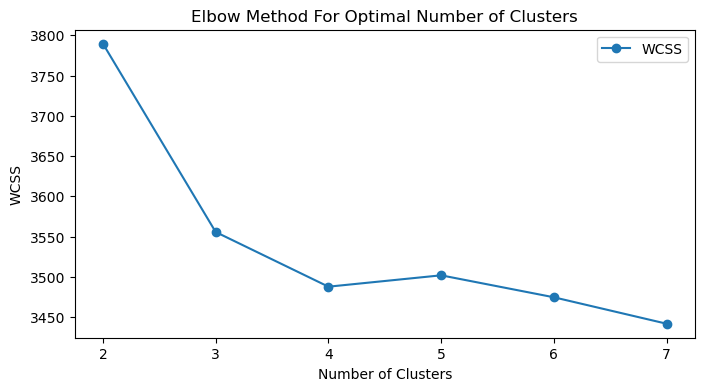

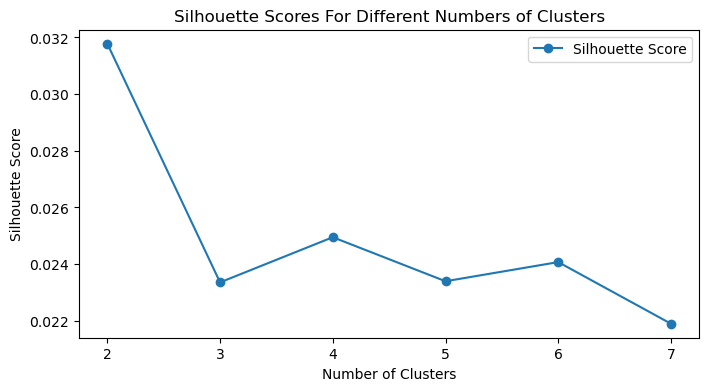

In [23]:
# Plotting the Elbow Method results
plt.figure(figsize=(8, 4))
plt.plot(range_clusters, wcss, marker='o', label='WCSS')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.legend()
plt.show()

# Plotting the Silhouette Analysis results
plt.figure(figsize=(8, 4))
plt.plot(range_clusters, silhouette_scores, marker='o', label='Silhouette Score')
plt.title('Silhouette Scores For Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()


## Best k for k-means

Since 4 phenotypes were found in the previous research, we will look at 4 clusters.
Silhouette Scores are best for 2 clusters, but 4 clusters shows a better ability to distinguish between groups in the data.  

In [25]:
# Build and train the model:
kmeans_model = H2OKMeansEstimator(k=4,
                                 estimate_k=True,
                                 standardize=False,
                                 seed=1234)

kmeans_model.train(training_frame=A_low_rank_rep,
                  validation_frame=B_glrm_data)


kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OKMeansEstimator : K-means
Model Key: KMeans_model_python_1725035253807_10


Model Summary: 
    number_of_rows    number_of_clusters    number_of_categorical_columns    number_of_iterations    within_cluster_sum_of_squares    total_sum_of_squares    between_cluster_sum_of_squares
--  ----------------  --------------------  -------------------------------  ----------------------  -------------------------------  ----------------------  --------------------------------
    1918              4                     0                                28                      3373.65                          4260.18                 886.525

ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 3373.6538353231226
Total Sum of Square Error to Grand Mean: 4260.179166276262
Between Cluster Sum of Square Error: 886.525330953139

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           1002    1072.93
    2           216     822.383
    3           292     446.315
    4           408     1032.03

ModelMetricsClustering: kmeans
** Reported on validation data. **

Total Within Cluster Sum of Square Error: 30385.963056007196
Total Sum of Square Error to Grand Mean: 31600.140575739875
Between Cluster Sum of Square Error: 1214.1775197326788

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           570     9027.67
    2           485     8042.1
    3           409     6633.77
    4           454     6682.42

Scoring History: 
     timestamp            duration    iterations    number_of_clusters    number_of_reassigned_observations    within_cluster_sum_of_squares
---  -------------------  ----------  ------------  --------------------  -----------------------------------  -------------------------------
     2024-08-30 17:28:11  0.013 sec   0.0           0.0                   nan                                  nan
     2024-08-30 17:28:11  0.043 sec   1.0           1.0                   1918.0                               7757.67156265593
     2024-08-30 17:28:11  0.045 sec   2.0           1.0                   0.0                                  4260.1791490694195
     2024-08-30 17:28:11  0.057 sec   3.0           2.0                   183.0                                3842.9557502105226
     2024-08-30 17:28:11  0.058 sec   4.0           2.0                   71.0                                 3791.937293271956
     2024-08-30 17:28:11  0.060 sec   5.0           2.0                   34.0                                 3777.347401764995
     2024-08-30 17:28:11  0.062 sec   6.0           2.0                   27.0                                 3773.4964485800874
     2024-08-30 17:28:11  0.064 sec   7.0           2.0                   6.0                                  3772.3252358580676
     2024-08-30 17:28:11  0.067 sec   8.0           2.0                   1.0                                  3772.1729392221114
     2024-08-30 17:28:11  0.068 sec   9.0           2.0                   5.0                                  3772.1575169413723
---  ---                  ---         ---           ---                   ---                                  ---
     2024-08-30 17:28:11  0.096 sec   19.0          3.0                   4.0                                  3526.292997412102
     2024-08-30 17:28:11  0.099 sec   20.0          3.0                   11.0                                 3526.106469116483
     2024-08-30 17:28:11  0.101 sec   21.0          3.0                   5.0                                  3525.6849364698583
     2024-08-30 17:28:11  0.106 sec   22.0          4.0                   123.0                                3411.57301551447
     2024-08-30 17:28:11  0.108 sec   23.0          4.0                   73.0                                 33

## Predict cluster labels


In [27]:
# Predict cluster labels for the low-rank representation of the data
cluster_labels = kmeans_model.predict(B_glrm_data)
print(cluster_labels.shape)

kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
(1918, 1)


In [28]:
# Convert to pandas DataFrame
cluster_labels_df = cluster_labels.as_data_frame()

# Add cluster assignments to the original data
clustered_data = agg_data.as_data_frame()
clustered_data['cluster'] = cluster_labels_df['predict'].astype(int)

# Convert complete data to pandas DataFrame 
data_df = data.as_data_frame()

/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster co

In [29]:
# Save cluster labels to drive
cluster_labels_df.to_csv('data/cluster_labels.csv', index=False)

In [30]:
# Shut down h2o session
h2o.cluster().shutdown()

H2O session _sid_9b5a closed.


In [31]:
clustered_data.head()

,period,sex,period_intensity,pain_level,backaches,bodyaches,stomach_cramps,joint_pains,tender_breasts,overall_pain,...,fever,hot_flashes,short_of_breath,coughing,insomnia,work_affected,weight,sleep,steps,cluster
0,1,1,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7744.500000,0
1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1,0,NaN,NaN,0.0,1.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,11666.666667,1
4,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


In [32]:
# Add 1 to each cluster number to rename clusters 1-4
clustered_data['cluster'] = clustered_data['cluster'] + 1

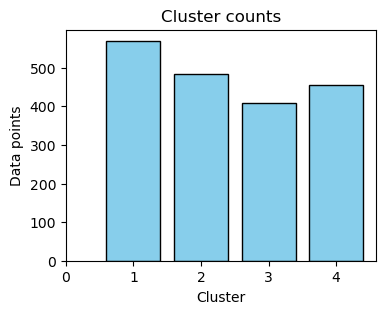

In [33]:
# Bar chart with data in each cluster
cluster, counts = np.unique(clustered_data['cluster'], return_counts=True)
plt.figure(figsize=(4, 3))
plt.bar(cluster, counts, color='skyblue', edgecolor='black')
plt.title('Cluster counts')
plt.xlabel('Cluster')
plt.ylabel('Data points')
plt.xticks(ticks=np.arange(5), labels=np.arange(0, 5))
plt.show()


SIGNIFICANT difference in pain_level levels between the clusters accoring to ANOVA.
                 sum_sq     df         F    PR(>F)
C(cluster)    98.925956    3.0  9.103712  0.000007
Residual    2068.267088  571.0       NaN       NaN


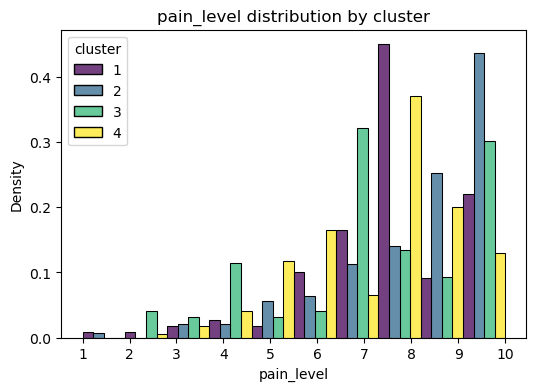


SIGNIFICANT difference in period_intensity levels between the clusters accoring to ANOVA.
                sum_sq     df         F    PR(>F)
C(cluster)   15.098555    3.0  3.262002  0.023616
Residual    202.116260  131.0       NaN       NaN


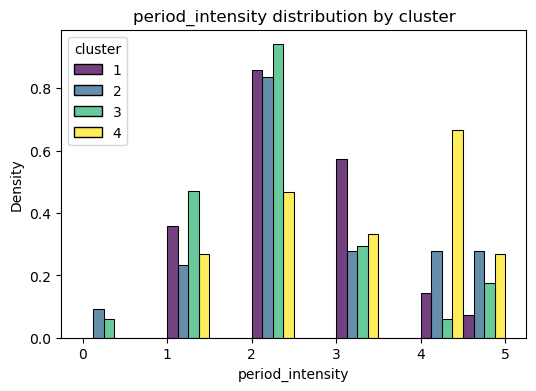


NO significant difference in overall_pain levels between the clusters accoring to ANOVA.
               sum_sq    df         F    PR(>F)
C(cluster)   2.206075   3.0  2.777721  0.053546
Residual    10.589379  40.0       NaN       NaN


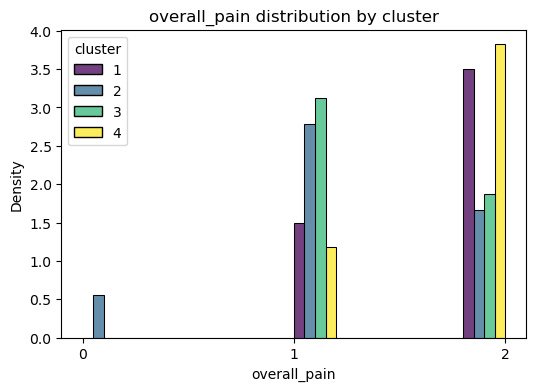


SIGNIFICANT difference in bloating levels between the clusters accoring to ANOVA.
                sum_sq     df         F    PR(>F)
C(cluster)    2.310804    3.0  2.691604  0.046064
Residual    104.167457  364.0       NaN       NaN


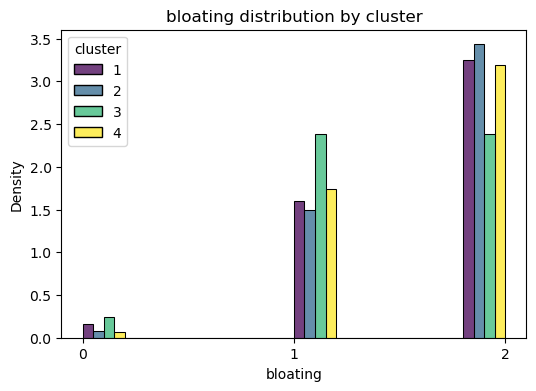


NO significant difference in appetite_loss levels between the clusters accoring to ANOVA.
               sum_sq     df         F    PR(>F)
C(cluster)   2.278259    3.0  1.576122  0.199689
Residual    49.628283  103.0       NaN       NaN


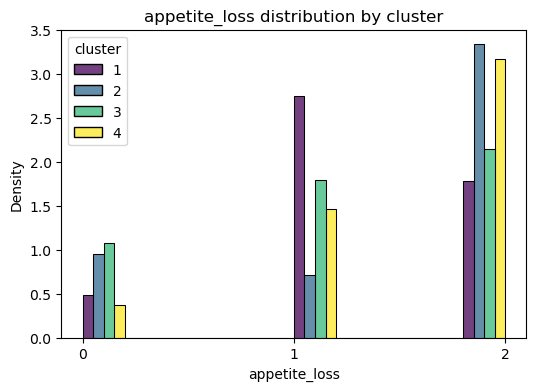


NO significant difference in tiredness levels between the clusters accoring to ANOVA.
               sum_sq     df        F    PR(>F)
C(cluster)   0.604267    3.0  1.09314  0.352327
Residual    53.066966  288.0      NaN       NaN


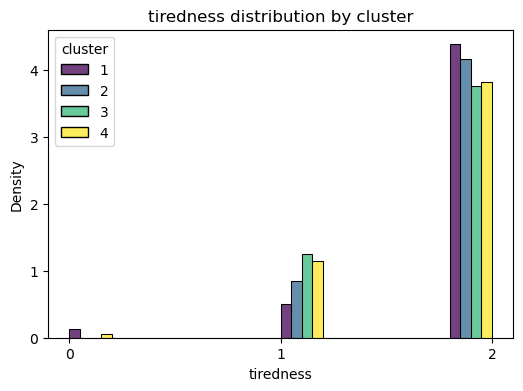


NO significant difference in fever levels between the clusters accoring to ANOVA.
               sum_sq    df         F    PR(>F)
C(cluster)   3.734142   3.0  2.619356  0.058514
Residual    29.937500  63.0       NaN       NaN


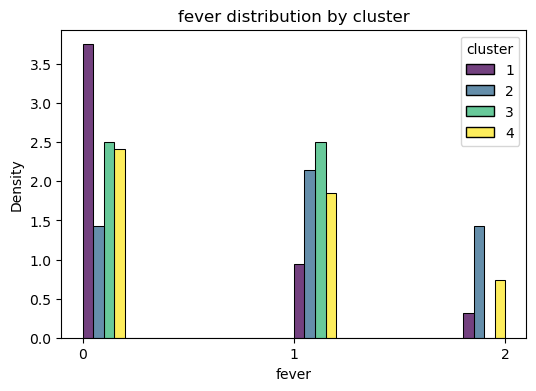


NO significant difference in steps levels between the clusters accoring to ANOVA.
                  sum_sq    df         F    PR(>F)
C(cluster)  1.564727e+07   3.0  0.593785  0.624685
Residual    2.283816e+08  26.0       NaN       NaN


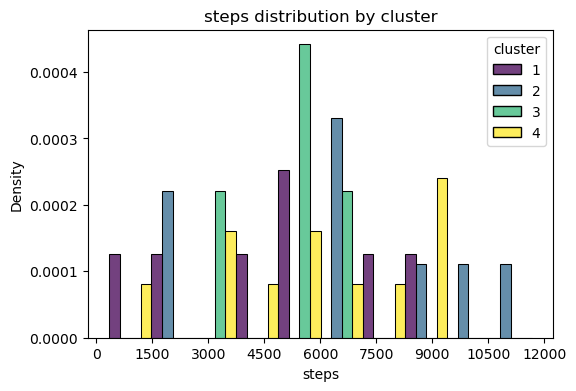


NO significant difference in weight levels between the clusters accoring to ANOVA.
                  sum_sq    df         F    PR(>F)
C(cluster)    985.498097   3.0  0.271106  0.845997
Residual    75125.325823  62.0       NaN       NaN


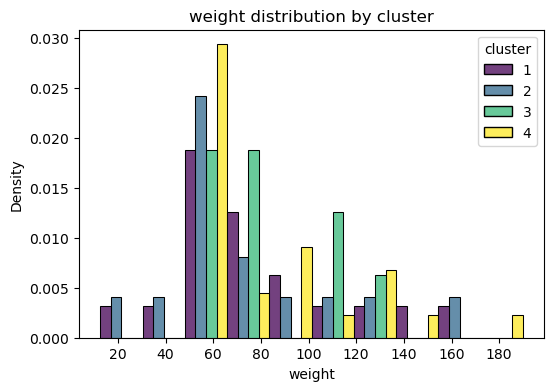


NO significant difference in backaches levels between the clusters accoring to ANOVA.
               sum_sq     df         F    PR(>F)
C(cluster)   0.965097    3.0  1.130535  0.336977
Residual    82.236268  289.0       NaN       NaN


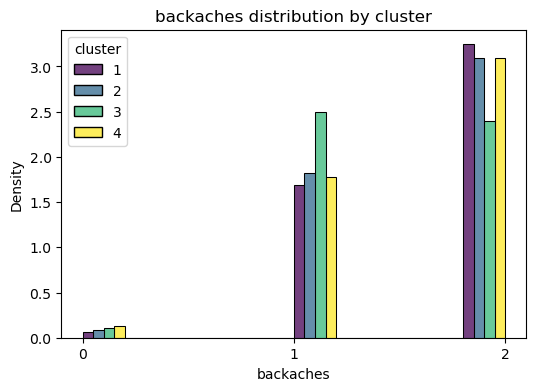


SIGNIFICANT difference in bodyaches levels between the clusters accoring to ANOVA.
               sum_sq     df        F    PR(>F)
C(cluster)   3.029207    3.0  3.61959  0.013855
Residual    65.556567  235.0      NaN       NaN


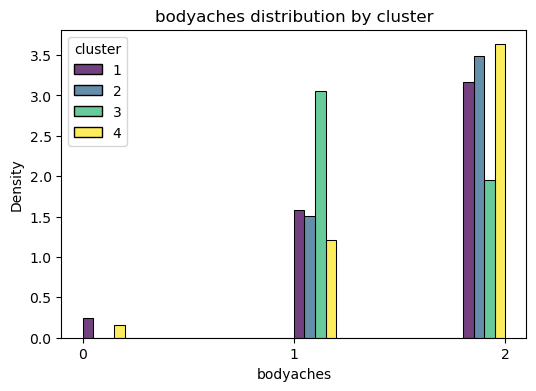


NO significant difference in stomach_cramps levels between the clusters accoring to ANOVA.
              sum_sq     df         F    PR(>F)
C(cluster)   1.78844    3.0  2.201758  0.088378
Residual    67.96058  251.0       NaN       NaN


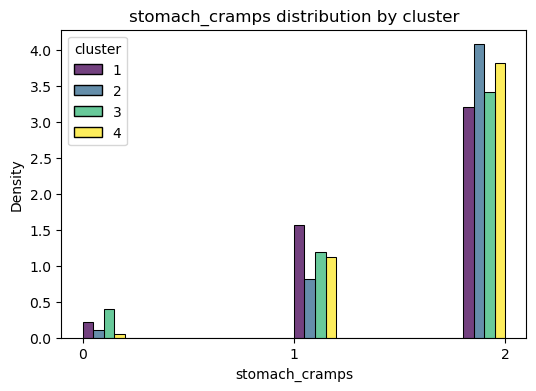


NO significant difference in headache levels between the clusters accoring to ANOVA.
               sum_sq     df         F    PR(>F)
C(cluster)   2.251013    3.0  1.627137  0.184214
Residual    94.533676  205.0       NaN       NaN


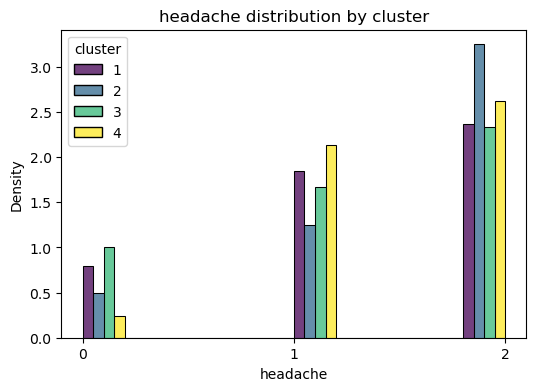


NO significant difference in indigestion levels between the clusters accoring to ANOVA.
               sum_sq    df         F    PR(>F)
C(cluster)   1.745436   3.0  1.018932  0.389341
Residual    41.683136  73.0       NaN       NaN


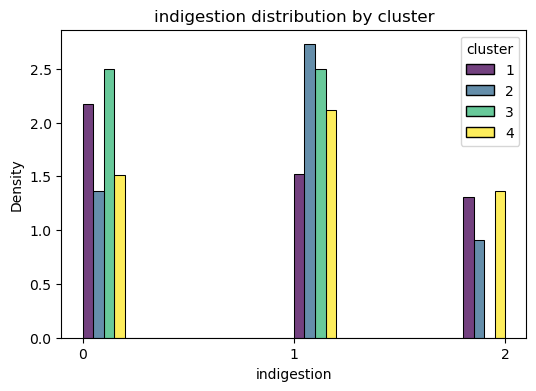


NO significant difference in constipation levels between the clusters accoring to ANOVA.
               sum_sq     df         F    PR(>F)
C(cluster)   1.480208    3.0  0.975804  0.406268
Residual    67.249719  133.0       NaN       NaN


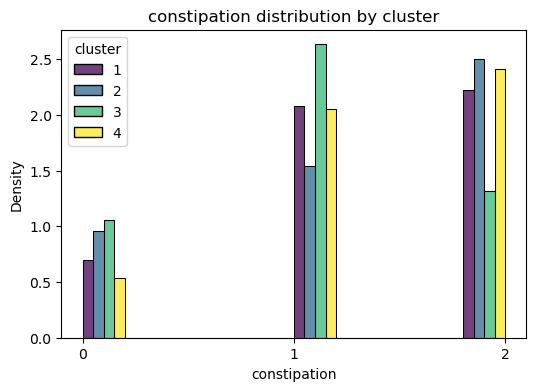


NO significant difference in diarrhea levels between the clusters accoring to ANOVA.
               sum_sq    df         F    PR(>F)
C(cluster)   1.799190   3.0  0.835308  0.477993
Residual    63.899735  89.0       NaN       NaN


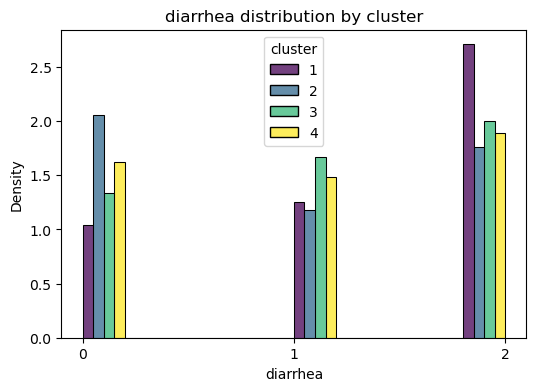


SIGNIFICANT difference in nausea levels between the clusters accoring to ANOVA.
               sum_sq     df         F    PR(>F)
C(cluster)   7.010192    3.0  5.262928  0.001708
Residual    74.147702  167.0       NaN       NaN


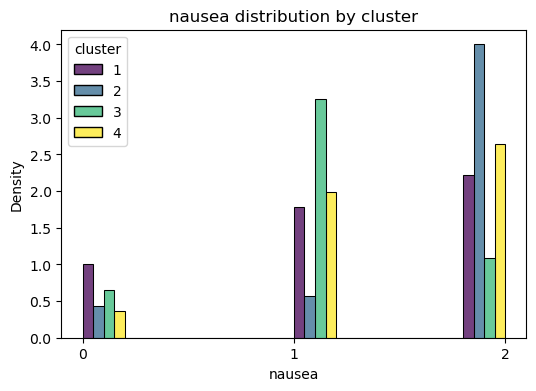


NO significant difference in vomiting levels between the clusters accoring to ANOVA.
               sum_sq    df         F    PR(>F)
C(cluster)   1.498474   3.0  0.828829  0.483702
Residual    33.145594  55.0       NaN       NaN


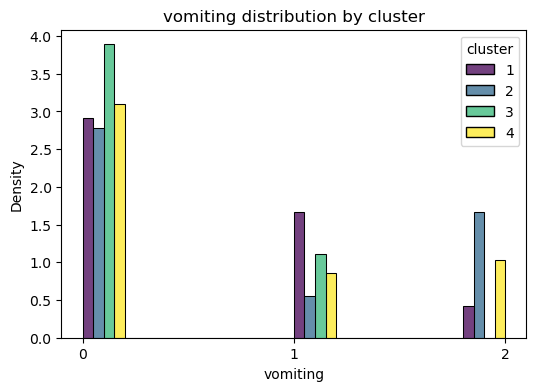


NO significant difference in temperature levels between the clusters accoring to ANOVA.
              sum_sq    df         F    PR(>F)
C(cluster)  2.680952   3.0  1.775465  0.215216
Residual    5.033333  10.0       NaN       NaN


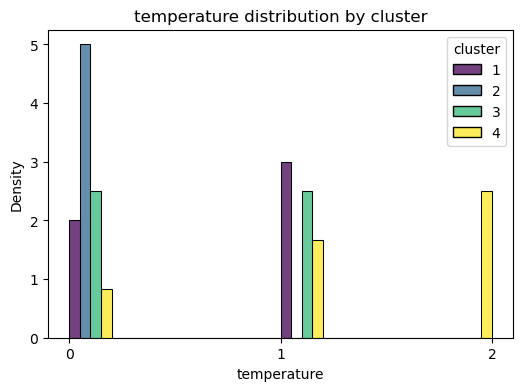


NO significant difference in hot_flashes levels between the clusters accoring to ANOVA.
               sum_sq    df         F    PR(>F)
C(cluster)   3.014912   3.0  1.760769  0.160728
Residual    49.085088  86.0       NaN       NaN


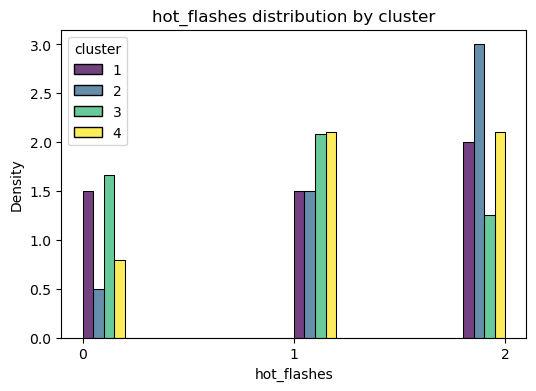


NO significant difference in insomnia levels between the clusters accoring to ANOVA.
               sum_sq     df         F    PR(>F)
C(cluster)   3.413423    3.0  2.638697  0.052777
Residual    50.881659  118.0       NaN       NaN


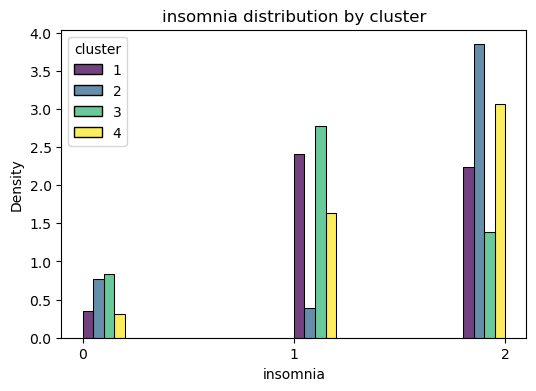


NO significant difference in sleep levels between the clusters accoring to ANOVA.
                   sum_sq    df         F    PR(>F)
C(cluster)   14212.160992   3.0  0.377809  0.769821
Residual    300938.657282  24.0       NaN       NaN


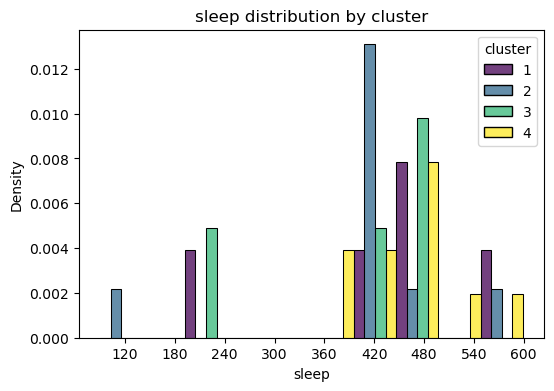


NO significant difference in work_affected levels between the clusters accoring to ANOVA.
              sum_sq    df         F    PR(>F)
C(cluster)  0.003571   3.0  0.009393  0.998731
Residual    5.196429  41.0       NaN       NaN


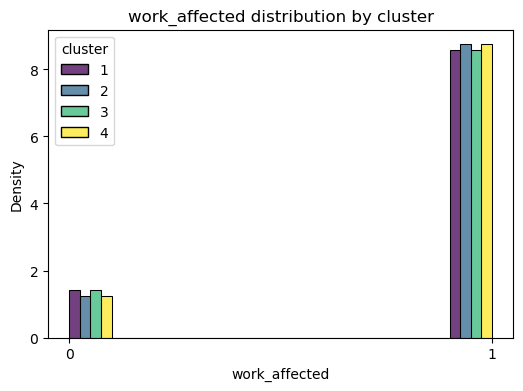

In [34]:
from matplotlib.ticker import MaxNLocator
# List of variables to plot
variables = ['pain_level', 'period_intensity', 'overall_pain', 'bloating', 'appetite_loss', 'tiredness', 'fever', 
             'steps', 'weight' ,'backaches','bodyaches', 'stomach_cramps', 'headache', 'indigestion', 'constipation',
             'diarrhea', 'nausea', 'vomiting', 'temperature', 'hot_flashes', 'insomnia', 'sleep', 'work_affected'] 

def plot_histogram_by_cluster(data, var):
    plt.figure(figsize=(6, 4))
    sns.histplot(data=data, x=var, hue='cluster', palette='viridis', element='bars',
                 stat='density', common_norm=False, bins=10, multiple="dodge")    
    plt.title(f'{var} distribution by cluster')
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.savefig(f'fig/cluster_dist_{var}.png', dpi=300)
    plt.show()

sig_var =[]
    
# Create distribution plots and ANOVA for each variable of interest by cluster
for var in variables:

    # ANOVA
    anova_model = ols(f'{var} ~ C(cluster)', data=clustered_data).fit()
    anova_results = anova_lm(anova_model, typ=2)
    # Interpretation
    alpha = 0.05
    p_value = anova_results['PR(>F)']['C(cluster)']
    
    if p_value < alpha:
        print(f'\nSIGNIFICANT difference in {var} levels between the clusters accoring to ANOVA.')
        sig_var.append(var)
    else:
        print(f'\nNO significant difference in {var} levels between the clusters accoring to ANOVA.')

    print(anova_results)
    plot_histogram_by_cluster(clustered_data, var)


In [35]:
print(sig_var)
#clustered_data.columns

['pain_level', 'period_intensity', 'bloating', 'bodyaches', 'nausea']


In [36]:
clustered_data.head()

,period,sex,period_intensity,pain_level,backaches,bodyaches,stomach_cramps,joint_pains,tender_breasts,overall_pain,...,fever,hot_flashes,short_of_breath,coughing,insomnia,work_affected,weight,sleep,steps,cluster
0,1,1,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7744.500000,1
1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,1,0,NaN,NaN,0.0,1.0,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,11666.666667,2
4,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4


In [37]:
# Drop columns with less significance
clustered_short = clustered_data.drop(columns=['sleep', 'weight', 'sex', 'period'])
#clustered_short = clustered_data[['cluster','pain_level','backaches','tiredness']]

In [38]:
clustered_filled = clustered_short.fillna(0)
cluster_sum = clustered_filled.groupby('cluster').sum()
cluster_sum = cluster_sum.reset_index()
cluster_sum

,cluster,period_intensity,pain_level,backaches,bodyaches,stomach_cramps,joint_pains,tender_breasts,overall_pain,headache,...,dizziness,pins_and_needles,temperature,fever,hot_flashes,short_of_breath,coughing,insomnia,work_affected,steps
0,1,66.0,945.0,121.0,95.0,112.0,54.0,43.0,17.0,75.0,...,58.0,12.0,3.0,5.0,22.0,10.0,12.0,40.0,12.0,33396.874384
1,2,113.0,1332.0,88.0,73.0,88.0,36.0,35.0,11.0,62.0,...,47.0,21.0,0.0,14.0,30.0,16.0,4.0,42.0,7.0,53658.529526
2,3,74.0,792.0,67.0,57.0,61.0,31.0,22.0,11.0,38.0,...,21.0,12.0,1.0,5.0,11.0,5.0,4.0,20.0,6.0,20412.200000
3,4,93.0,1414.0,188.0,161.0,172.0,78.0,72.0,30.0,121.0,...,63.0,33.0,8.0,18.0,48.0,38.0,19.0,76.0,14.0,63531.583333


In [39]:
# Normalise pain_level, weight, sleep, steps to a scale range
max = 210
min = 70

cluster_sum['pain_level'] = (cluster_sum['pain_level'] - cluster_sum['pain_level'].min()) / (cluster_sum['pain_level'].max() - cluster_sum['pain_level'].min()) * (max - min) + min
cluster_sum['steps'] = (cluster_sum['steps'] - cluster_sum['steps'].min()) / (cluster_sum['steps'].max() - cluster_sum['steps'].min()) * (max - min) + min
cluster_sum.head()

,cluster,period_intensity,pain_level,backaches,bodyaches,stomach_cramps,joint_pains,tender_breasts,overall_pain,headache,...,dizziness,pins_and_needles,temperature,fever,hot_flashes,short_of_breath,coughing,insomnia,work_affected,steps
0,1,66.0,104.437299,121.0,95.0,112.0,54.0,43.0,17.0,75.0,...,58.0,12.0,3.0,5.0,22.0,10.0,12.0,40.0,12.0,112.158637
1,2,113.0,191.543408,88.0,73.0,88.0,36.0,35.0,11.0,62.0,...,47.0,21.0,0.0,14.0,30.0,16.0,4.0,42.0,7.0,177.944172
2,3,74.0,70.000000,67.0,57.0,61.0,31.0,22.0,11.0,38.0,...,21.0,12.0,1.0,5.0,11.0,5.0,4.0,20.0,6.0,70.000000
3,4,93.0,210.000000,188.0,161.0,172.0,78.0,72.0,30.0,121.0,...,63.0,33.0,8.0,18.0,48.0,38.0,19.0,76.0,14.0,210.000000


In [40]:
# Custom colours for grouped symptoms
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    color_mapping = {
        
        # Blues
        'sex': '#4682B4',
        'period': '#000080',
        'skin_changes': '#87CEFA',
        'weight': '#4169E1',
        'sleep': '#000080',
        'water': '#8FBC8F',
        'steps': '#4682B4',

        # Purples
        'tiredness':'#9370DB', 
        'dizziness':'#9932CC', 
        'pins_and_needles':'#4169E1',
        'insomnia':'#DA70D6',
        'hot_flashes': '#8A2BE2',
        'acne': '#9400D3',
        'skin_changes': '#9400D3',
        'fever': '#C9A0DC',
        'temperature': '#E6E6FA',
        'short_of_breath': '#B19CD9',
        'coughing': '#B19CD9',
        'work_affected':'#9932EC', 
        
        # Reds
        'pain_level': '#DC143C',
        'period_intensity': '#FF6347',
        'overall_pain':"#B22222",   
        'backaches': '#CD5C5C', 
        'bodyaches': '#FA8072',
        'stomach_cramps': '#E9967A' , 
        'joint_pains':'#FF7F50', 
        'tender_breasts': '#F08080', 
        'headache':"#B22222", 

        # Browns
        'indigestion':"#A0522D",
        'bloating':"#8B4513", 
        'constipation':'brown', 
        'diarrhea':'#D2691E',
        'nausea':'#F4A460', 
        'vomiting':'#E69F00', 
        'appetite_loss':'#BC8F8F', 
        'cravings_salty':"#B8860B", 
        'cravings_sweet': "#DEB887", 
        
    }
    return color_mapping.get(word, "black") 

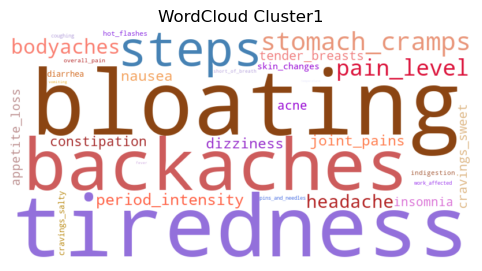

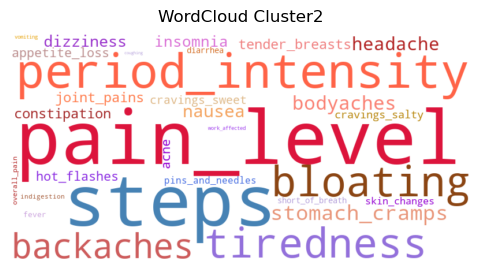

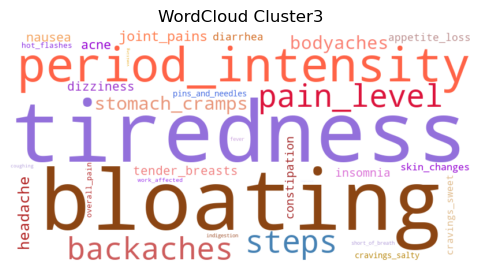

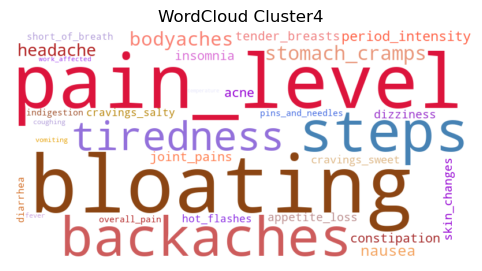

In [41]:
# Create WordCloud for each cluster
def create_wordcloud(row, title, var):
    # Dictionary with column names as words and values as frequencies
    col_value = row.to_dict()
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate_from_frequencies(col_value)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.savefig(f'fig/wordcloud_sum_{var}.png', dpi=300)  
    plt.show()

for index, row in cluster_sum.iterrows():
    create_wordcloud(row.drop('cluster'), title=f'WordCloud Cluster{round(row["cluster"])}', var=round(row["cluster"]))